
## Titanic - Machine Learning from Disaster - Predicting the Survival of Titanic Passengers


### Load the libraries

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import warnings 

# Pre-processing, model selection and tuning techniques 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

# Algorithms - Unsupervised Learning
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Algorithms - Supervised Learnin - classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Other classifiers if you would like to explore (optional) 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

pd.set_option('display.max_columns', 100)
pd.set_option("display.precision", 2)

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load the data

Kaggle’s Titanic Machine Learning Dataset – a classic open-source introduction to the realm of machine learning. The link for the competition and data is https://www.kaggle.com/competitions/titanic. The dataset has information about different passengers on the Titanic ship and their survival. We have the following features in our dataset: 

- survival -> Survival -> 0 = No, 1 = Yes
- pclass -> Ticket class -> 1 = 1st, 2 = 2nd, 3 = 3rd
- sex -> Sex
- Age -> Age in years
- sibsp -> # of siblings / spouses aboard the Titanic
- parch -> # of parents / children aboard the Titanic
- ticket -> Ticket number
- fare -> Passenger fare
- cabin -> Cabin number
- embarked -> Port of Embarkment

#### Data Notes 

- As part of the Kaggle competition, based on the patterns you find in titanic_known.csv, you will have to predict whether the other 418 passengers on board in titanic_unknown.csv survived.

**Note that titanic_unknown.csv does not have a "Survived" column - this information is hidden from you, and how well you do at predicting these hidden values will determine how highly you score in the competition!**

In [2]:
# The data in this use case are provided to you as titanic_known.csv and titanic_unknown.csv files. 
# Load both of the files into two new DataFrames titanicData and unknownData respectively

titanicData = pd.read_csv('data/titanic_known.csv')
unknownData = pd.read_csv('data/titanic_unknown.csv')

Get the dimensionality and preview the known titanicData:

In [3]:
# Print the dimensionality of titanicData and preview its first rows
# Take a moment to familiarize yourselves with the entries in the dataset (and their data types) 
# Have you detected the class variable that we are trying to predict? 

print(titanicData.shape)
titanicData.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


The training-set has 891 examples and 11 features + the target variable (survived).  

Get the dimensionality and preview the test data:

In [4]:
# Print the dimensionality of unknownData and preview its first rows
# Familiarize yourselves with the entries in the dataset (and their data types) 

# !! Note that titanic_unknown.csv does not have a "Survived" column - this information is hidden from you, 
# and how well you do at predicting these hidden values will determine how highly you score in the actual Kaggle competition! 
# (they screen the results against the hidden classes only the owners possess) 

# !! The unknownData set mimics a real-world scenario of new, unseen data arriving at some point through any real-world (production) model,
# and the model's task will be to predict them using all the learning and generalization capabilities we have leveraged from our known data. 

print(unknownData.shape)
unknownData.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.29,NaN,S


#### Observations 

Note: From the previews above, we can note a few things. 
- First of all, that we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them. 
- Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale. 
- We can also spot some more features, that contain missing values (NaN = not a number), that we'll need to deal with.

### Check the data types and missing values of each column 

- Which features are categorical?
- Which features are numerical?

#### 1) Train data

2 of the features are floats, 5 are integers and 5 are objects.

In [5]:
# Get the data types or relevant info of titanicData 

# titanicData.dtypes
titanicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Check for missing values per column in titanicData  

# titanicData.isna().any()  
# pd.DataFrame({'percent_missing': titanicData.isnull().sum() * 100 / len(titanicData)})
pd.DataFrame({'sum_missing': titanicData.isnull().sum()}) 

,sum_missing
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


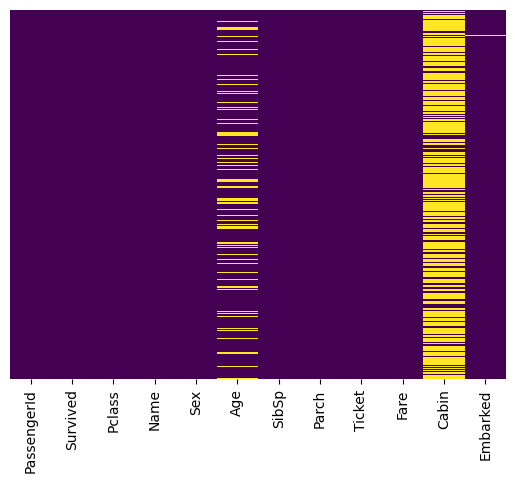

In [7]:
# Extra - optional : Plot the null values heatmap for titanicData

sns.heatmap(titanicData.isnull(), yticklabels=False, cbar=False, cmap='viridis');

We notice from the above that the known set has missing values in the Age, Cabin and Embarked columns

#### 2) Unknown data

In [8]:
# Get the data types or relevant info of unknownData 

# unknownData.dtypes
unknownData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [9]:
# Check for missing values in unknownData 

# unknownData.isna().any()  
# pd.DataFrame({'percent_missing': unknownData.isnull().sum() * 100 / len(unknownData)})
pd.DataFrame({'sum_missing': unknownData.isnull().sum()}) 

,sum_missing
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


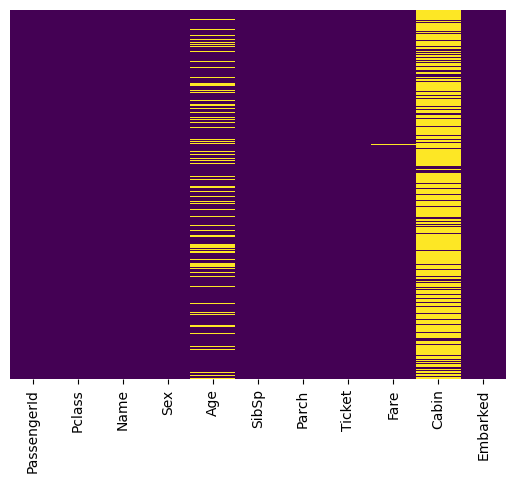

In [10]:
# Extra - optional : Plot the null values heatmap for unknownData

sns.heatmap(unknownData.isnull(), yticklabels=False, cbar=False, cmap='viridis');

**The unknown set has missing values in Age, Cabin and Fare columns**

The Embarked feature has only 2 missing values in the train set, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation.

### Feature engineering and feature creation 

#### 1. Drop any unnecessary values 

##### Handling the passenger ID

In [11]:
# How would you deal with PassengerId in titanicData? Come up with a solution. Ensure your changes have gone through 

# Set it as index. Alternatively, drop the column
titanicData.set_index('PassengerId', inplace=True) 
titanicData.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C


In [12]:
# How would you deal with PassengerId in unknownData? Come up with a solution. Ensure your changes have gone through  

# Set it as index. Alternatively, drop the column
unknownData.set_index('PassengerId', inplace=True) 
unknownData.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.83,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.00,NaN,S


#### 2. Optional --- Feature creation 

##### Optional --- Extract the titles 

We could use the Name feature to extract the Titles so that we can build a new feature out of that.

In [13]:
titanicData['Title'] = ''
unknownData['Title'] = ''

for i in titanicData:
    titanicData['Title'] = titanicData.Name.str.extract('([A-Za-z]+)\.') 

for i in unknownData:
    unknownData['Title'] = unknownData.Name.str.extract('([A-Za-z]+)\.')
    
titanicData.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C,Mrs


In [14]:
# Optional: execute pd.crosstab() on the combination of titanicData['Title'] and titanicData['Sex'] 

pd.crosstab(titanicData['Title'], titanicData['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as a new value 'Other'

In [15]:
for dataset in [titanicData, unknownData]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

titanicData[['Title', 'Survived']].groupby(['Title'], as_index=False).count()

,Title,Survived
0,Master,40
1,Miss,185
2,Mr,517
3,Mrs,126
4,Other,23


##### 3. Optional --- Work with the Cabin data

As a first thought, we can delete the ‘Cabin’ feature but there's something rather interesting. A cabin number looks like ‘C123’ and the letter refers to the deck. Therefore we could extract these and create a new feature, that contains a person's deck. Afterwards, we will convert the feature into a numeric variable. The missing values will be converted to zero. The actual decks of the titanic are ranging from A to G.

In [16]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [titanicData, unknownData]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("X")
    dataset['Deck']  = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck']  = dataset['Deck'].map(deck)
    dataset['Deck']  = dataset['Deck'].fillna(0)
    dataset['Deck']  = dataset['Deck'].astype(int)

titanicData.Deck.value_counts()

Deck
0    688
3     59
2     47
4     33
5     32
1     15
6     13
7      4
Name: count, dtype: int64

##### 4. Optional --- Combine SibSp and Parch

SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. We can create it as follows and also create a feature that shows if someone is not alone.

In [17]:
data = [titanicData, unknownData]

for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

titanicData[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).count().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
0,1,537
1,2,161
2,3,102
3,4,29
5,6,22
4,5,15
6,7,12
8,11,7
7,8,6


In [18]:
for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

titanicData[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).count()

,IsAlone,Survived
0,0,354
1,1,537


##### 5. Handling (Dropping) the Name,  Ticket and Cabin columns if NOT used

In [19]:
# Drop the features ['Name', 'Ticket','Cabin'] of your titanicData - set the axis accordingly - inplace or with replacement. 
# Preview the first 2 rows of titanicData
 
titanicData = titanicData.drop(['Name', 'Ticket','Cabin'], axis=1) 
titanicData.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.25,S,Mr,0,2,0
2,1,1,female,38.0,1,0,71.28,C,Mrs,3,2,0


In [20]:
# Drop the features ['Name', 'Ticket','Cabin'] of your unknownData - set the axis accordingly - inplace or with replacement. 
# Preview the first 2 rows of unknownData

unknownData = unknownData.drop(['Name', 'Ticket','Cabin'], axis=1)
unknownData.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamilySize,IsAlone
PassengerId,,,,,,,,,,,
892,3,male,34.5,0,0,7.83,Q,Mr,0,1,1
893,3,female,47.0,1,0,7.00,S,Mrs,0,2,0


### Split to X and y

In [21]:
# The most common step across all Supervised Machine Learning models in Python
# The first thing you have to ask is what is the label (dependent) variable/column? 

# Store the feature data from titanicData into a new variable named "X" - Extract all columns **except** 
# from the label column using either indexing (.loc / .iloc) or, easier, .drop()

X = titanicData.drop('Survived', axis=1)

# Store the target data (label/class column) from titanicData into a new variable named "y"
# Get only the label (class) from titanicData 

########## FILL IN YOUR SOLUTION HERE ########## 

y = titanicData["Survived"]

# Print the dimensions (using "shape") for both X and y 

########## FILL IN YOUR SOLUTION HERE ########## 

print ("X dimensions: ", X.shape)
print ("y dimensions: ", y.shape)

X dimensions:  (891, 11)
y dimensions:  (891,)


In [22]:
# Print the entries of y. Do you need to apply LabelEncoding on y? What do you think?

y 

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64


### Check the Survival rate (target variable y)

In [23]:
# In order to check the counts of the binary class, use the function .value_counts() on y 

########## FILL IN YOUR SOLUTION HERE ########## 

y.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

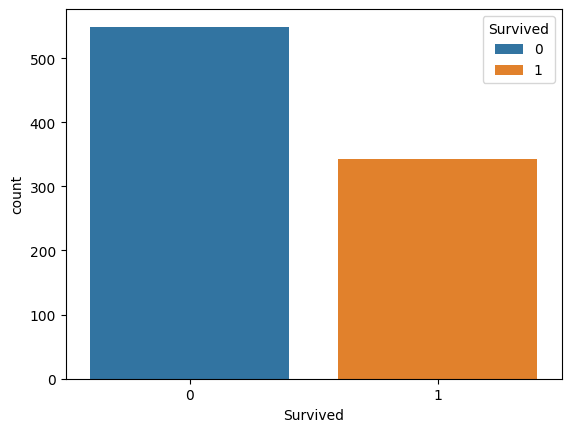

In [24]:
# Use the sns.countplot() function from seaborn to plot the feature "Survived" from titanicData
# Optional: set also the hue to "Survived" 

########## FILL IN YOUR SOLUTION HERE ########## 

sns.countplot(x="Survived", hue="Survived", data=titanicData);

It is evident that not many passengers survived the accident.

Out of 891 passengers in training set, only around 350 survived i.e Only 38.4% of the total training set survived the crash. 

### Train/test split

As mentioned previously, the test (unknown) file provided is used for competition submission. 

So, we will use the sklearn function to split the known data in two datasets. This is important, so we don't overfit our model. Meaning, the algorithm is so specific to a given subset, it cannot accurately generalize another subset, from the same dataset. It's important our algorithm has not seen the subset we will use to test, so it doesn't "cheat" by memorizing the answers. We will use sklearn's train_test_split function.

In [25]:
# Use the train_test_split() function from sklearn. Use 30% of your data for the test set. Use stratification if needed. 
# Set random_state=1 (for reproducibility). Print the dimensionality (shape) of X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    stratify = y, 
                                                    random_state=1)

print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

Shape of x_train and y_train:  (623, 11) (623,)
Shape of x_test and y_test:  (268, 11) (268,)


### Imputing 

In the case of missing values, we should take care to replace them in the dataset as they prevent machine learning algorithms to run. There are many functions such as `.fillna()` and `.SimpleImputer` from `sklearn` as well as **many strategies** to help with missing data and they depend on whether the missing data is **numeric** or **categorical**.  

What strategy is best for you problem very much depends on the specifics of your dataset. However, generally speaking it is not worth to remove large chunks of data.

- simply removing rows where there is missing data (e.g. `dropna()` can achieve this)
- imputing the values with a summary statistic such as mean or median or most frequent value (e.g. `.fillna()` from `pandas` or `.SimpleImputer()` from `sklearn` module)
- replace the values with a reasonable estimate

In [26]:
# Let's quickly print the NAs per dataset 

print("Nulls in X_train","-"*20)
print(X_train.isnull().sum())

print("Nulls in X_test","-"*20)
print(X_test.isnull().sum())

print("Nulls in unknownData","-"*20)
print(unknownData.isnull().sum())

Nulls in X_train --------------------
Pclass          0
Sex             0
Age           122
SibSp           0
Parch           0
Fare            0
Embarked        2
Title           0
Deck            0
FamilySize      0
IsAlone         0
dtype: int64
Nulls in X_test --------------------
Pclass         0
Sex            0
Age           55
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
Deck           0
FamilySize     0
IsAlone        0
dtype: int64
Nulls in unknownData --------------------
Pclass         0
Sex            0
Age           86
SibSp          0
Parch          0
Fare           1
Embarked       0
Title          0
Deck           0
FamilySize     0
IsAlone        0
dtype: int64


In [27]:
# We will need one Imputer for the numerical features and one for the categorical features 
# 1. Instantiate the SimpleImputer for the numerical features using as strategy the 'median'. Assign to a variable named 'imp_num'
# 2. Instantiate the SimpleImputer for the categorical features using as strategy the 'most_frequent'. Assign to a variable named 'imp_cat' 

imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [28]:
# Impute your numerical data using the imp_num Imputer : 

# 1. .fit_tranform() your imp_num Imputer **ONLY** on the numerical columns of X_train that contain NAs (X_train[['Age', 'Fare']]). 
# Remember: we only fit() on the trainData but transform() all the DataFrames after the learning process. 
# Assign back only to X_train[['Age', 'Fare']] 
# 2. .transform() the numerical columns of X_test that contain NAs (X_test[['Age', 'Fare']]). Assign back only to X_test[['Age', 'Fare']] 
# 3. .transform() the numerical columns of unknownData that contain NAs (unknownData[['Age', 'Fare']]). Assign back only to unknownData[['Age', 'Fare']]  

X_train[['Age', 'Fare']]     = imp_num.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']]      = imp_num.transform(X_test[['Age', 'Fare']])
unknownData[['Age', 'Fare']] = imp_num.transform(unknownData[['Age', 'Fare']])


In [29]:
# Impute your categorical data using the imp_cat Imputer: 

# 1. .fit_tranform() your imp_cat Imputer ONLY on the categorical columns of X_train that contain NAs (X_train[['Embarked']]). 
# Remember: we only fit() on the trainData but transform() all the DataFrames after the learning process.
# Assign back only to X_train[['Embarked']] 
# 2. .transform() the numerical columns of X_test that contain NAs (X_test[['Embarked']]). Assign back only to X_test[['Embarked']]  
# 3. .transform() the numerical columns of unknownData that contain NAs (unknownData[['Embarked']]). Assign back only to unknownData[['Embarked']]  


X_train[['Embarked']]     = imp_cat.fit_transform(X_train[['Embarked']])
X_test[['Embarked']]      = imp_cat.transform(X_test[['Embarked']])
unknownData[['Embarked']] = imp_cat.transform(unknownData[['Embarked']])


In [30]:
# Print once more the NA count as above. Did your changes go through? 

print("Nulls in X_train","-"*20)
print(X_train.isnull().sum())

print("Nulls in X_test","-"*20)
print(X_test.isnull().sum())

print("Nulls in unknownData","-"*20)
print(unknownData.isnull().sum())

Nulls in X_train --------------------
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Deck          0
FamilySize    0
IsAlone       0
dtype: int64
Nulls in X_test --------------------
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Deck          0
FamilySize    0
IsAlone       0
dtype: int64
Nulls in unknownData --------------------
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Deck          0
FamilySize    0
IsAlone       0
dtype: int64


### Convert the categorical features with One-Hot-Encoding (OHE) 

In [31]:
# Check the X_train data types with .dtypes once more to detect the categorical columns 
# Which are the categorical features in this case? You should detect three of them after our feature engineering/creation 

X_train.dtypes

Pclass          int64
Sex            object
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
Title          object
Deck            int64
FamilySize      int64
IsAlone         int64
dtype: object

In [32]:
# Apply one-hot-encoding (OHE) to the categorical features of X_train using pd.get_dummies: 

# 1. Create a new variable "X_train_ohe" and assign the subset of X_train that contains only the (three) categorical features that need to be encoded
# 2. As a second step, apply pd.get_dummies(X_train_ohe, dtype=int) and assign back to the variable 'X_train_ohe' to overwrite the entries of the dataframe.  
# 3. Remove (drop) the (three) categorical features from X_train (you may need to set the axis accordingly!). Drop with inplace=True OR with assignment back to X_train
# 4. Use .join() on X_train with X_train_ohe (contains the result of one hot encoding). Assign back to X_train to overwrite the entries. 
# Preview the first few rows of X_train. Did your changes go through? 

X_train_ohe = X_train[['Sex', 'Embarked','Title']]
X_train_ohe = pd.get_dummies(X_train_ohe, dtype=int)

X_train = X_train.drop(['Sex', 'Embarked','Title'], axis = 1)
X_train = X_train.join(X_train_ohe)

X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Deck,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
PassengerId,,,,,,,,,,,,,,,,,,
473,2,33.0,1,2,27.75,0,4,0,1,0,0,0,1,0,0,0,1,0
598,3,49.0,0,0,0.00,0,1,1,0,1,0,0,1,0,0,1,0,0
844,3,34.5,0,0,6.44,0,1,1,0,1,1,0,0,0,0,1,0,0
113,3,22.0,0,0,8.05,0,1,1,0,1,0,0,1,0,0,1,0,0
870,3,4.0,1,1,11.13,0,3,0,0,1,0,0,1,1,0,0,0,0


In [33]:
# Similarly, apply one-hot-encoding (OHE) to the categorical features of *X_test* using pd.get_dummies: 

X_test_ohe = X_test[['Sex', 'Embarked','Title']]
X_test_ohe = pd.get_dummies(X_test_ohe, dtype=int)

X_test = X_test.drop(['Sex', 'Embarked','Title'], axis = 1)
X_test = X_test.join(X_test_ohe)

X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Deck,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
PassengerId,,,,,,,,,,,,,,,,,,
434,3,17.0,0,0,7.12,0,1,1,0,1,0,0,1,0,0,1,0,0
222,2,27.0,0,0,13.00,0,1,1,0,1,0,0,1,0,0,1,0,0
218,2,42.0,1,0,27.00,0,2,0,0,1,0,0,1,0,0,1,0,0
377,3,22.0,0,0,7.25,0,1,1,1,0,0,0,1,0,1,0,0,0
448,1,34.0,0,0,26.55,0,1,1,0,1,0,0,1,0,0,1,0,0


In [34]:
# Similarly, apply one-hot-encoding (OHE) to the categorical features of *unknownData* using pd.get_dummies: 

X_unknown_ohe = unknownData[['Sex', 'Embarked','Title']]
X_unknown_ohe = pd.get_dummies(X_unknown_ohe, dtype=int)

unknownData = unknownData.drop(['Sex', 'Embarked','Title'], axis = 1)
unknownData = unknownData.join(X_unknown_ohe)

unknownData.head()

,Pclass,Age,SibSp,Parch,Fare,Deck,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
PassengerId,,,,,,,,,,,,,,,,,,
892,3,34.5,0,0,7.83,0,1,1,0,1,0,1,0,0,0,1,0,0
893,3,47.0,1,0,7.00,0,2,0,1,0,0,0,1,0,0,0,1,0
894,2,62.0,0,0,9.69,0,1,1,0,1,0,1,0,0,0,1,0,0
895,3,27.0,0,0,8.66,0,1,1,0,1,0,0,1,0,0,1,0,0
896,3,22.0,1,1,12.29,0,3,0,1,0,0,0,1,0,0,0,1,0



#### Check for correlations in the data - Pearson Correlation Heatmap

Let's look at the correlations among the numerical variables in our dataset. This information is important to know as there are Machine Learning algorithms (for example, linear and logistic regression) that do not handle highly correlated input variables well.

First, we will use the method [`corr()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) on a `DataFrame` that calculates the correlation between each pair of features. Then, we pass the resulting *correlation matrix* to [`heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) from `seaborn`, which renders a color-coded matrix for the provided values:

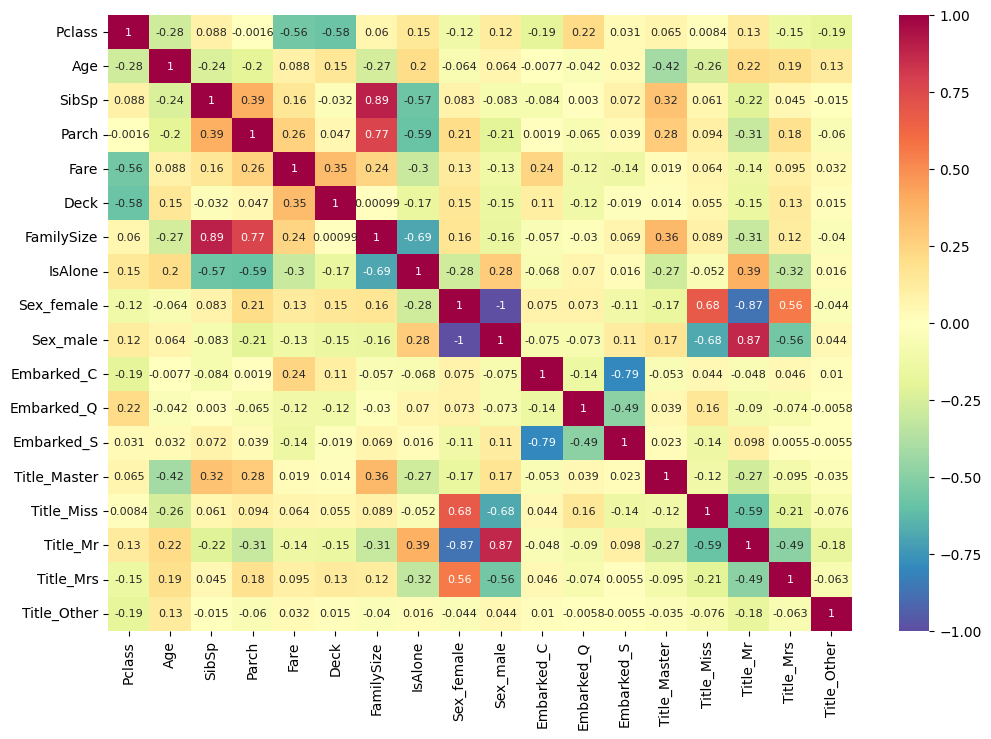

In [35]:
# Calculate the correlation matrix of X_train DataFrame using the .corr() function and 
# save it in a variable called 'corr_matrix'. Then pass the corr_matrix to the sns.heatmap() function for plotting. 
# Optional: you can use f, ax = plt.subplots(figsize=(12, 8))  
# Optional sns.heatmap arguments : annot=True,  annot_kws={'size': 8} and cmap="Spectral_r" 

########## FILL IN YOUR SOLUTION HERE ########## 


corr_matrix = X_train.corr()

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            annot_kws={'size': 8}, 
            cmap="Spectral_r");

### Check the distributions

#### What are the ranges of the various features? 

In [36]:
# Apply the .describe() function on the X_train

X_train.describe()

,Pclass,Age,SibSp,Parch,Fare,Deck,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
count,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.00,623.0,623.00,623.00,623.00
mean,2.31,29.09,0.54,0.39,31.72,0.84,1.93,0.59,0.35,0.65,0.19,0.08,0.73,0.05,0.2,0.58,0.15,0.02
std,0.84,12.76,1.13,0.80,46.92,1.64,1.62,0.49,0.48,0.48,0.39,0.27,0.44,0.22,0.4,0.49,0.35,0.15
min,1.00,0.42,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
25%,2.00,22.00,0.00,0.00,7.92,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
50%,3.00,28.50,0.00,0.00,14.46,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.0,1.00,0.00,0.00
75%,3.00,35.00,1.00,0.00,31.27,0.00,2.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.0,1.00,0.00,0.00
max,3.00,74.00,8.00,6.00,512.33,7.00,11.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00


/var/folders/5g/fcbnwv7s16344nm4h15fl6rc0000gn/T/ipykernel_11888/11734818.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


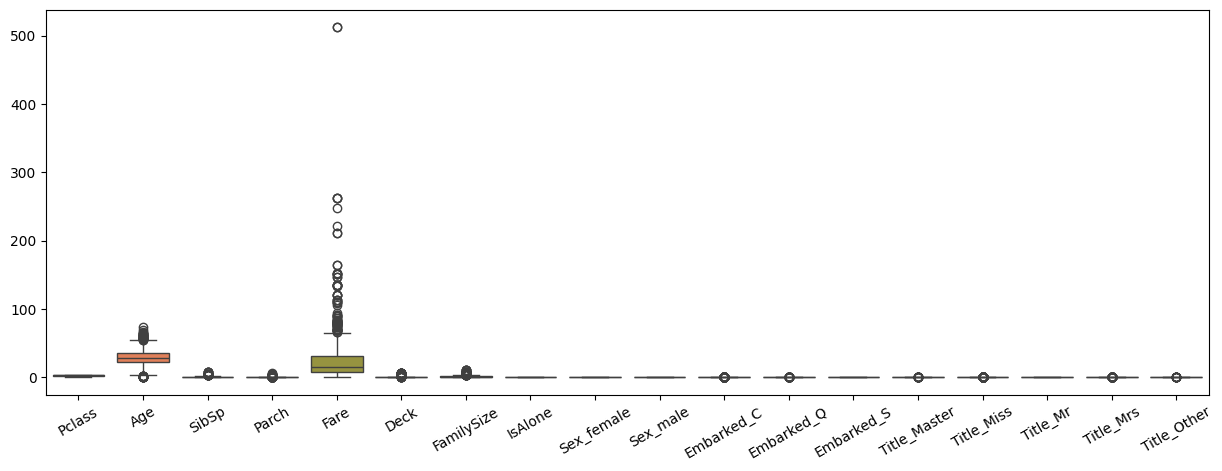

In [37]:
# Visualise the X_train data in a seaborn boxplot. Optional: set the plt.figure(figsize=(15,10))

plt.figure(figsize=(15,5))
ax = sns.boxplot(data=X_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

### Scaling

Most Machine Learning algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X_train to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results.

In [38]:
# 1. Instantiate the StandardScaler() or MinMaxScaler(). Store into a variable named "scaler" 

# 2. Fit the scaler ONLY on the X_train data - Use the scaler.fit_transform() on the X_train set 
# You will also need to convert the results of scaler.fit_transform() back to a pandas DataFrame by calling pd.DataFrame() with
# columns=X_train.columns. Assign the result back to the variable X_train. 

# 3. Transform (do not fit!) the test dataset using the (fitted) scaler. Use the scaler.transform() on the X_test. 
# You will also need to convert the results of scaler.fit_transform() back to a pandas DataFrame by calling pd.DataFrame() with
# columns=X_test.columns. Assign the result back to the variable X_test.  

# 4. Transform (do not fit!) the test dataset using the (fitted) scaler. Use the scaler.transform() on the unknownData. 
# You will also need to convert the results of scaler.fit_transform() back to a pandas DataFrame by calling pd.DataFrame() with
# columns=unknownData.columns. Assign the result back to the variable unknownData. 


scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
unknownData = pd.DataFrame(scaler.transform(unknownData), columns=unknownData.columns)

/var/folders/5g/fcbnwv7s16344nm4h15fl6rc0000gn/T/ipykernel_11888/352123781.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


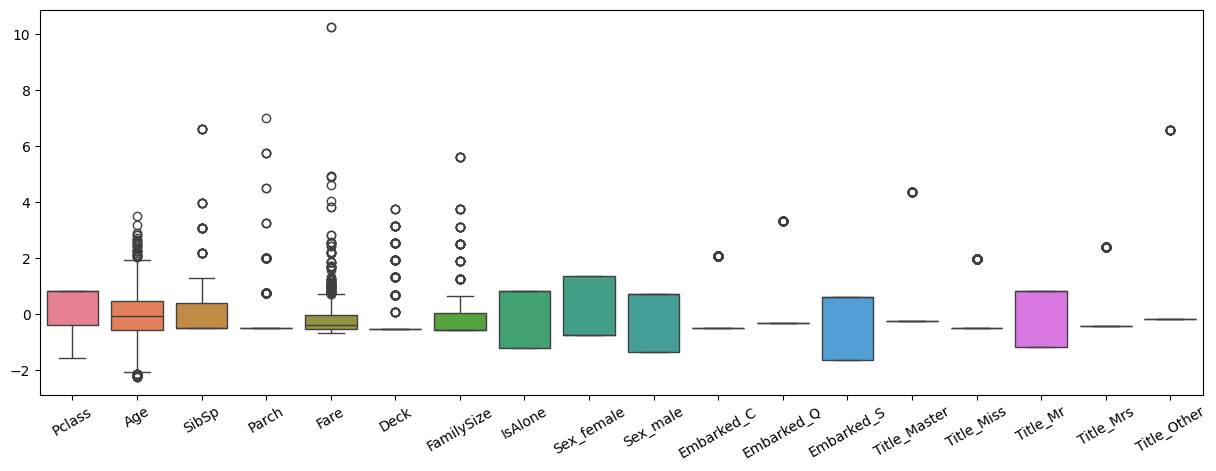

In [39]:
# Run once more the boxplot on the scaled X_train data

plt.figure(figsize=(15,5))
ax = sns.boxplot(data= X_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

### Kmeans clustering on the results of PCA 

#### PCA 

In scikit-learn, PCA is implemented as a transformer object that learns `n` components in its `fit()` method, and can be used on new data to project it on these components. More information on how to use the `pca()` function and its parameters can be found at http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [40]:
# 1) Instantiate the PCA() object by passing as argument the value 0.90 (the cut-off variance value we would like to reach) 
# and store in a new variable "pca"
# 2) Apply pca.fit_transform() on the X_train data and store into a new variable named "pc_scores"
# 3) Print the PCA cummulative variance 

pca = PCA(0.90)
pc_scores = pca.fit_transform(X_train)
pca.explained_variance_ratio_.cumsum()

array([0.24543486, 0.40464068, 0.5308399 , 0.63416645, 0.70512513,
       0.76642069, 0.82220096, 0.87502025, 0.90860824])

In [41]:
# Create a feature name for each Principal Component (such as PC1, PC2, ...) up to the detected number of current dimensions

PCs = ['PC'+str(i+1) for i in range(pc_scores.shape[1])]

In [42]:
# Convert the pc_scores to a pandas DataFrame using pd.DataFrame() and pass as the columns argument the PCs list that was created in the prevous step
# Assign back to pc_scores. Preview the first entries of pc_scores 

pc_scores = pd.DataFrame(pc_scores, columns=PCs)
pc_scores.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,3.26,0.37,0.25,-1.73,2.09,0.03,0.24,0.05,0.87
1,-2.36,0.01,-0.24,-0.90,0.59,0.03,-0.41,0.22,-0.02
2,-1.93,-0.59,-0.04,2.23,1.07,-0.67,0.55,0.88,-0.34
3,-2.08,0.49,-0.74,-0.49,-0.13,-0.41,0.29,0.13,0.16
4,0.99,3.74,-0.94,0.45,-1.16,0.30,2.99,-1.47,0.57


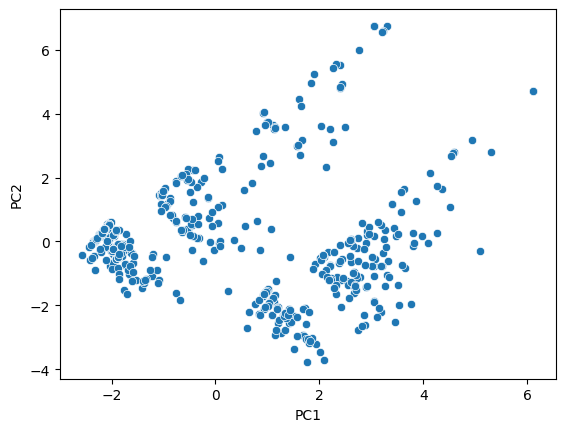

In [43]:
# Plot the first 2 Principal Components ("PC1" vs. "PC2") in a seaborn scatterplot 
# Optional/extra: Should you wish, you can join the y_train class label in the pc_scores and use it as hue in the scatterplot 

sns.scatterplot(x="PC1", y="PC2", data=pc_scores)
plt.show();

#### 2. K-means

#### Elbow method 

Elbow Method : There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. The elbowpoint is the point where the rate of decrease of mean distance i.e. SSE will not change significantly with increase in number of clusters.

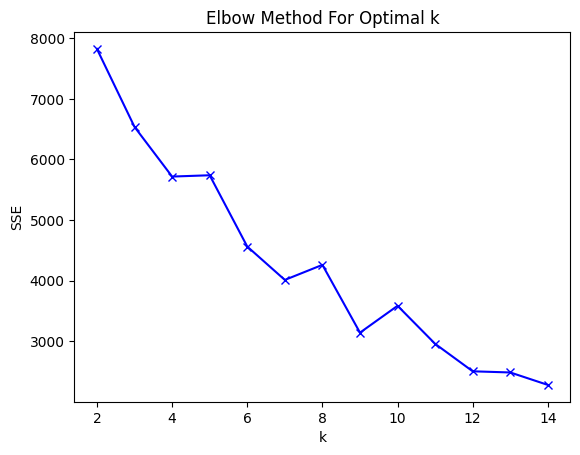

In [44]:
# Can you run the elbow rule to find the optimal number of K for kmeans that we need to use on our pc_scores?? 

# Create an empty list for sum of squared distances to be appended for k values 2 to 15
Sum_of_squared_distances = [] 

# Values for K (centroids) 
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters =k)
    km = km.fit(pc_scores)
    
    # model.inertia_: Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided 
    # (from documentation - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

In [45]:
# 1) Instantiate a KMeans object with n_clusters equal to the **OPTIMAL k** as found above and store it in a variable named "kmodel" 
# 2) .fit() the kmodel model on the pc_scores(!!) data 
# 3) Use the .labels_ parameter on kmodel to get the assinged clusters and save the results in a new variable "cluster_assignment".
# 4) Save the output of cluster_assignment to pc_scores["KMCluster"]  
# 5) Preview the first few rows of pc_scores

kmodel = KMeans(n_clusters=4)
kmodel.fit(pc_scores)
cluster_assignment = kmodel.labels_
pc_scores["KMCluster"] = cluster_assignment
pc_scores.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,KMCluster
0,3.26,0.37,0.25,-1.73,2.09,0.03,0.24,0.05,0.87,0
1,-2.36,0.01,-0.24,-0.90,0.59,0.03,-0.41,0.22,-0.02,2
2,-1.93,-0.59,-0.04,2.23,1.07,-0.67,0.55,0.88,-0.34,1
3,-2.08,0.49,-0.74,-0.49,-0.13,-0.41,0.29,0.13,0.16,2
4,0.99,3.74,-0.94,0.45,-1.16,0.30,2.99,-1.47,0.57,3


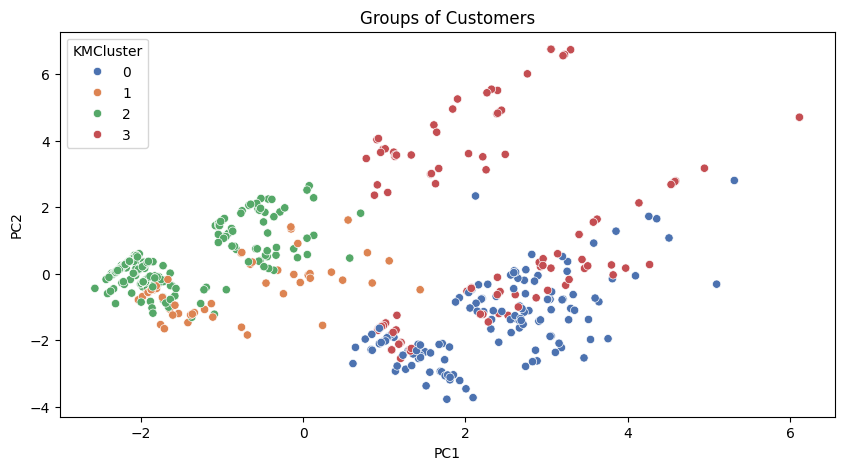

In [46]:
# Plot the 2 Principal Components (PC scores) in a scatterplot using the "KMCluster" as hue

plt.figure(figsize=(10,5))

sns.scatterplot(x='PC1', 
                y='PC2', 
                data=pc_scores, 
                hue= "KMCluster",
                palette="deep"
               ).set_title('Groups of Customers')

plt.show()

## Model, predict and solve

### Classifiers - Predict using the *subset* test set (not the unknown yet) 

In [47]:
# Create an empty DataFrame to store and compare all evaluation results (performance metrics) across all classifiers 

clf_results = pd.DataFrame([])

#### 1a. Support Vector Machine (RBF) - benchmark model (default parameters)

In [48]:
# Step 1 - Instantiate the SVC() classifier using the default parameters (Default hyperparameters are C=1.0, kernel=rbf and gamma=auto) 
# Assign the result into a new variable named "rbf_svm" 
# Step 2 - Fit the rbf_svm model to the training set (X_train, y_train)
# Step 3 - Predict the test data (X_test) using the rbf_svm model and assign to "y_pred_rbf_svm" 
# Step 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

rbf_svm = SVC()
rbf_svm.fit(X_train, y_train)
y_pred_rbf_svm = rbf_svm.predict(X_test)

print('Accuracy for RBF SVM is:', round(metrics.accuracy_score(y_test, y_pred_rbf_svm), 3))
print('\n', metrics.classification_report(y_test, y_pred_rbf_svm))

Accuracy for RBF SVM is: 0.84

               precision    recall  f1-score   support

           0       0.84      0.92      0.88       165
           1       0.85      0.71      0.77       103

    accuracy                           0.84       268
   macro avg       0.84      0.81      0.82       268
weighted avg       0.84      0.84      0.84       268



In [49]:
# Add the results of the benchmark SVM classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Benchmark RBF SVM', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rbf_svm), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_rbf_svm), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77


#### 1b. Linear SVM - benchmark model (default parameters)

In [50]:
# 1. Instantiate the SVC classifier with a linear kernel. Assign the result into a new variable named "linear_svm" 
# Step 2 - Fit the linear_svm model to the training set (X_train, y_train)
# Step 3 - Predict the test data (X_test) using the linear_svm model and assign to "y_pred_linear_svm"
# Step 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)
y_pred_linear_svm =linear_svm.predict(X_test)

print('Accuracy for Linear SVM is:', round(metrics.accuracy_score(y_test, y_pred_linear_svm), 3))
print('\n', metrics.classification_report(y_test, y_pred_linear_svm))

Accuracy for Linear SVM is: 0.821

               precision    recall  f1-score   support

           0       0.82      0.91      0.86       165
           1       0.82      0.68      0.74       103

    accuracy                           0.82       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268



In [51]:
# Add the results of the benchmark SVM classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Benchmark Linear SVM', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_linear_svm), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_linear_svm), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Benchmark Linear SVM,0.82,0.74


#### 1c. Optimal SVM - SVM hyperparameter tuning

Proper choice of C and gamma is critical to the SVM’s performance. **One is advised to use GridSearchCV with `C` and `gamma` spaced exponentially far apart to choose good values.** Detailed information on the SVM hyperparameters can be found at https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py 

As a first step, create a dictionary of hyperparameter ranges and conduct a grid or random search with cross-validation:

In [52]:
# Use GridSearchCV() with 5-fold or 10-fold cross-validation (cv=5 or cv=10) on the SVC() classifier 
# (more cv folds reduces the chances of overfitting but also increases the run time) 
# 1. Create the dictionary of hyperparameters for the SVM (SVC classifier) 
# 2. Set up the GridSearchCV and assign to a new variable named svm_grid_cv. 
# Optional: You can experiment with the scoring options (you need to check the documentation)
# 3. Fit svm_grid_cv to X_train and y_train 
# 4. Report the optimal parameters using 'cv_svm.best_params_'

param_grid = [ {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                'kernel':['rbf'], 
                'gamma':[1, 0.1, 0.01, 0.001, 0.0001,'auto','scale']},
             ]

svm_grid_cv = GridSearchCV(SVC(),
                           param_grid=param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

svm_grid_cv.fit(X_train, y_train)

print('Best Parameters using grid search: ', svm_grid_cv.best_params_)

Best Parameters using grid search:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [53]:
# 1. Build the (optimal) classifier using the optimal parameters detected by the tuning process. Assign to a new variable svm_opt. 
# Note: you can use either svm_grid_cv.best_estimator_ to retrieve the model or the svm_grid_cv.best_params_ from above into a new SVC()
# 2 - Fit the svm_opt model to the training set (X_train)
# 3 - Predict the test data (X_test) using the svm_opt model. Assign to a variable named y_pred_svm_opt
# 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

svm_opt = svm_grid_cv.best_estimator_
svm_opt.fit(X_train, y_train) 
y_pred_svm_opt = svm_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_svm_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_svm_opt))

Test set accuracy:  0.84

               precision    recall  f1-score   support

           0       0.84      0.92      0.88       165
           1       0.85      0.71      0.77       103

    accuracy                           0.84       268
   macro avg       0.84      0.81      0.82       268
weighted avg       0.84      0.84      0.84       268



In [54]:
# Add the results of the optimal SVM classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Tuned SVM', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_svm_opt), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_svm_opt), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Benchmark Linear SVM,0.82,0.74
0,Tuned SVM,0.84,0.77


#### 2a. KNN - benchmark model (default parameters)

In [55]:
# Step 1 - Instantiate the KNeighborsClassifier() classifier using the default parameters  
# Assign the result into a new variable named "knn" 
# Step 2 - Fit the knn model to the training set (X_train, y_train)
# Step 3 - Predict the test data (X_test) using the knn model. Assign to y_pred_knn
# Step 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

knn = KNeighborsClassifier() 
knn.fit(X_train, y_train) 
y_pred_knn = knn.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_knn), 3))
print('\n', metrics.classification_report(y_test, y_pred_knn))

Test set accuracy:  0.806

               precision    recall  f1-score   support

           0       0.82      0.87      0.85       165
           1       0.77      0.70      0.73       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.81      0.80       268



In [56]:
# Use GridSearchCV() with 5-fold or 10-fold cross-validation (cv=5 or cv=10) on KNeighborsClassifier() 
# (more cv folds reduces the chances of overfitting but also increases the run time) on the KNeighborsClassifier classifier 
# 1. Create the dictionary of hyperparameters for KNN
# 2. Set up the GridSearchCV and assign to a new variable named knn_grid_cv
# 3. Fit the grid or random search model to X_train and y_train 
# 4. Report the optimal parameters

knn_param_grid = dict(n_neighbors = np.arange(1, 101, 2), 
                      weights = ['uniform', 'distance'], 
                      metric = ['minkowski','euclidean','manhattan'])

knn_grid_cv = GridSearchCV(KNeighborsClassifier(), 
                           knn_param_grid, 
                           cv=5)

knn_grid_cv.fit(X_train, y_train) 

# Report the optimal parameters
print("Best parameters: ", knn_grid_cv.best_params_)

Best parameters:  {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}


In [57]:
# Build the classifier using the optimal parameters detected by the tuning process
# Note: you can use either knn_grid_cv.best_estimator_ to retrieve the optimal model. Assign to knn_opt.  
# 2 - Fit the knn_opt model to the training set (X_train, y_train)
# 3 - Predict the test data (X_test) using the knn_opt model. Assign to a variable named y_pred_knn_opt
# 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

knn_opt = knn_grid_cv.best_estimator_
knn_opt.fit(X_train, y_train) 
y_pred_knn_opt = knn_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_knn_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_knn_opt))

Test set accuracy:  0.828

               precision    recall  f1-score   support

           0       0.83      0.91      0.87       165
           1       0.83      0.70      0.76       103

    accuracy                           0.83       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.83      0.83       268



In [58]:
# Add the results of the optimal KNN classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Tuned KNN',
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_knn_opt),3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_knn_opt), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Benchmark Linear SVM,0.82,0.74
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76


#### 3a. Random Forest - benchmark model (default parameters)

In [59]:
# Step 1 - Instantiate the RandomForestClassifier(random_state=0) classifier using the default parameters  
# Assign the result into a new variable named "rf" 
# Step 2 - Fit the rf model to the training set (X_train, y_train)
# Step 3 - Predict the test data (X_test) using the rf model. Assign to y_pred_rf 
# Step 4 - Print the final overall accuracy and classification_report for the test set (X_test) 


rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Accuracy for Random Forest is ', round(metrics.accuracy_score(y_test, y_pred_rf), 3))
print('\n', metrics.classification_report(y_test, y_pred_rf))

Accuracy for Random Forest is  0.821

               precision    recall  f1-score   support

           0       0.84      0.88      0.86       165
           1       0.79      0.73      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



In [60]:
# Add the results as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Benchmark RF',
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rf),3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_rf), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Benchmark Linear SVM,0.82,0.74
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76


#### 3b. Optimal RF - tune the RF hyperparameters with RandomizedSearchCV( )

In [61]:
# Use GridSearchCV() with 5-fold or 10-fold cross-validation (cv=5 or cv=10)
# (more cv folds reduces the chances of overfitting but also increases the run time) on the RandomForestClassifier(random_state=0) classifier 
# 1. Create the dictionary of hyperparameters for RF
# 2. Set up the **RandomSearchCV**  and assign to a new variable named cv_rf
# 3. Fit cv_rf to X_train and y_train 
# 4. Report the optimal parameters


param_grid = {'n_estimators': np.arange(10, 300, 10),
              'max_features' : ['sqrt', 'log2', None], 
              'max_depth': [None, 3, 5, 10, 20], 
             }

# Set up the RandomSearchCV and assign to a new variable named cv_rf
# The most important arguments in RandomizedSearchCV are n_iter, 
# which controls the number of different combinations to try, 
# and cv which is the number of folds to use for cross validation 
cv_rf = RandomizedSearchCV(RandomForestClassifier(random_state=0), 
                           param_distributions=param_grid, 
                           n_iter = 50,
                           cv = 5,
                           n_jobs = -1,
                           random_state=0)

# Fit the grid or random search model to X_train and y_train 
cv_rf.fit(X_train, y_train)

# Report the optimal parameters using 'cv_rf.best_params_'
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'n_estimators': 40, 'max_features': None, 'max_depth': 5}


In [62]:
# Build the classifier using the optimal parameters detected by the tuning process.
# Note: you can use either cv_rf.best_estimator_ to retrieve the optimal model. Assign to rf_opt.  
# 2 - Fit the rf_opt model to the training set (X_train, y_train)
# 3 - Predict the test data (X_test) using the rf_opt model. Assign to a variable named y_pred_rf_opt
# 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

rf_opt = cv_rf.best_estimator_
rf_opt.fit(X_train, y_train) 
y_pred_rf_opt = rf_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_rf_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_rf_opt))

Test set accuracy:  0.821

               precision    recall  f1-score   support

           0       0.82      0.91      0.86       165
           1       0.82      0.68      0.74       103

    accuracy                           0.82       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268



In [63]:
# Add the results of the optimal KNN classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Tuned Random Forest',
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rf_opt),3),  
                                                         'F1': round(metrics.f1_score(y_test, y_pred_rf_opt), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Benchmark Linear SVM,0.82,0.74
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76
0,Tuned Random Forest,0.82,0.74


/var/folders/5g/fcbnwv7s16344nm4h15fl6rc0000gn/T/ipykernel_11888/3659976908.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_scores.index, size = 20)


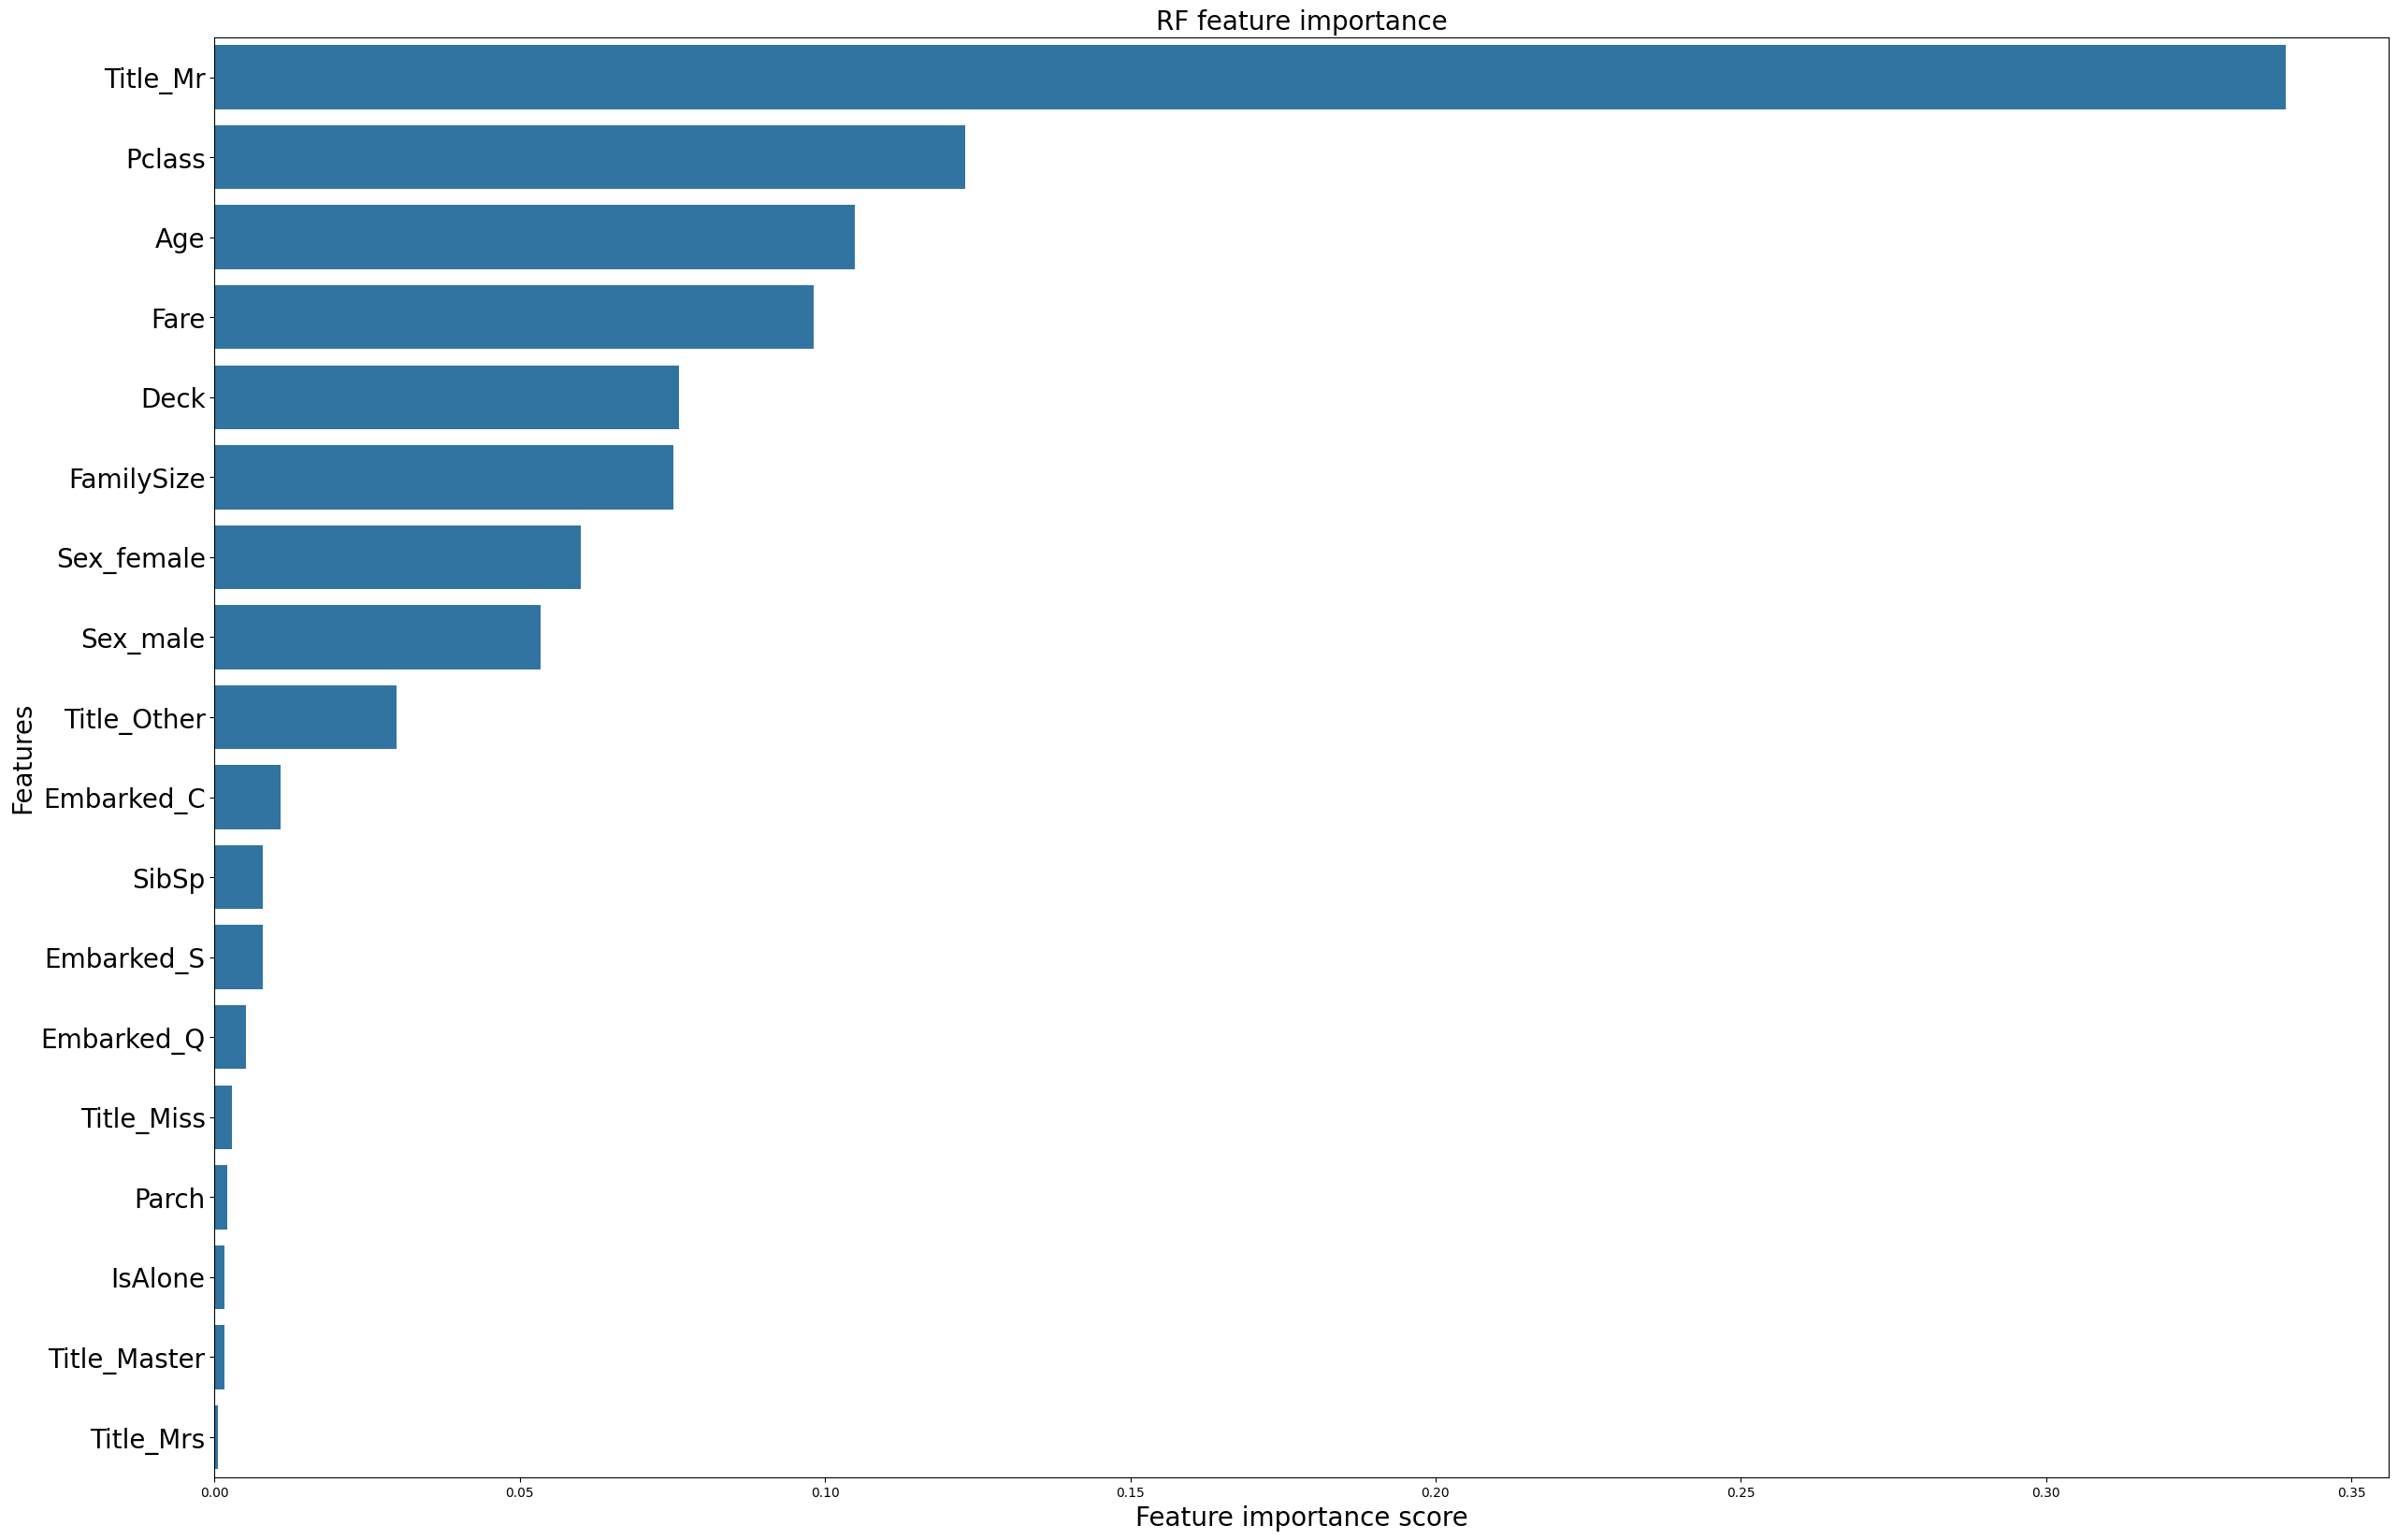

In [64]:
# Get the feature importance from the rf classifier using rf_opt.feature_importances_
# Cast it into a pd.DataFrame and use sort_values to sort by the importance 
# Plot the rf_opt.feature_importances_ in a barplot

feature_scores = pd.DataFrame(rf_opt.feature_importances_, 
                              index=X_train.columns, 
                              columns=['Importance'])

feature_scores.sort_values(by='Importance', ascending=False, inplace=True) 

 
f, ax = plt.subplots(figsize=(30, 20))
ax = sns.barplot(x='Importance', y=feature_scores.index, data=feature_scores)
ax.set_title("RF feature importance", size = 20)
ax.set_yticklabels(feature_scores.index, size = 20)
ax.set_xlabel("Feature importance score", size = 20)
ax.set_ylabel("Features", size = 20)
plt.show()

#### 4. Decision Tree - benchmark model (default parameters)

In [65]:
# Step 1 - Instantiate the DecisionTreeClassifier() classifier using the default parameters  
# Assign the result into a new variable named "dt" 
# Step 2 - Fit the dt model to the training set (X_train, y_train)
# Step 3 - Predict the test data (X_test) using the dt model. Assign to y_pred_dt
# Step 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

dt = DecisionTreeClassifier() 
dt.fit(X_train, y_train)  
y_pred_dt = dt.predict(X_test)  

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_dt), 3))
print('\n', metrics.classification_report(y_test, y_pred_dt))

Test set accuracy:  0.784

               precision    recall  f1-score   support

           0       0.81      0.84      0.83       165
           1       0.73      0.69      0.71       103

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



In [66]:
##### (time-dependent): YOU CAN TUNE THE PARAMETERS OF DT TO FIND THE OPTIMAL MODEL #####

In [67]:
# Add the results of the optimal KNN classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Benchmark Decision Tree',
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_dt),3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_dt), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Benchmark Linear SVM,0.82,0.74
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76
0,Tuned Random Forest,0.82,0.74
0,Benchmark Decision Tree,0.78,0.71


### Compare the models 

In [68]:
clf_results.sort_values(by='F1', ascending=False, inplace=True)
clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76
0,Benchmark Linear SVM,0.82,0.74
0,Tuned Random Forest,0.82,0.74
0,Benchmark Decision Tree,0.78,0.71


#### (OPTIONAL) Other models: Logistic Regression - benchmark model (default parameters) 

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. 

In [69]:
# Step 1 - Instantiate the LogisticRegression() classifier using the default parameters  
# Assign the result into a new variable named "logreg" 
# Step 2 - Fit the logreg model to the training set (X_train)
# Step 3 - Predict the test data (X_test) using the logreg model 
# Step 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_logreg), 3))
print('\n', metrics.classification_report(y_test, y_pred_logreg))

Test set accuracy:  0.828

               precision    recall  f1-score   support

           0       0.84      0.90      0.87       165
           1       0.81      0.72      0.76       103

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.83      0.83      0.83       268



In [70]:
##### YOU CAN TUNE THE PARAMETERS OF LOGISTIC REGRESSION TO FIND THE OPTIMAL MODEL #####

In [71]:
# Add the results of the optimal KNN classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'LogisticRegression',
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_logreg),3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_logreg), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76
0,Benchmark Linear SVM,0.82,0.74
0,Tuned Random Forest,0.82,0.74
0,Benchmark Decision Tree,0.78,0.71
0,LogisticRegression,0.83,0.76


#### (OPTIONAL) Other models: ExtraTreesClassifier - benchmark model (default parameters)

In [72]:
# Step 1 - Instantiate the ExtraTreesClassifier() classifier using the default parameters  
# Assign the result into a new variable named "extc" 
# Step 2 - Fit the extc model to the training set (X_train)
# Step 3 - Predict the test data (X_test) using the extc model 
# Step 4 - Print the final overall accuracy and classification_report for the test set (X_test) 

extc = ExtraTreesClassifier()
extc.fit(X_train, y_train)
y_pred_extc = extc.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_extc), 3))
print('\n', metrics.classification_report(y_test, y_pred_extc))

Test set accuracy:  0.799

               precision    recall  f1-score   support

           0       0.82      0.87      0.84       165
           1       0.76      0.69      0.72       103

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



In [73]:
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100,300],
                  "criterion": ["gini"]}


cv_extc = RandomizedSearchCV(ExtraTreesClassifier(random_state=0), 
                           param_distributions=ex_param_grid, 
                           n_iter = 50,
                           cv = 5,
                           n_jobs = -1,
                           random_state=0)

cv_extc.fit(X_train, y_train)

print('Best Parameters using grid search: \n', cv_extc.best_params_)

Best Parameters using grid search: 
 {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


In [74]:
# Build the classifier using the optimal parameters detected by the tuning process

extc_opt = cv_extc.best_estimator_
extc_opt.fit(X_train, y_train) 
y_pred_extc_opt = extc_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_extc_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_extc_opt))

Test set accuracy:  0.84

               precision    recall  f1-score   support

           0       0.84      0.92      0.88       165
           1       0.84      0.72      0.77       103

    accuracy                           0.84       268
   macro avg       0.84      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268



/var/folders/5g/fcbnwv7s16344nm4h15fl6rc0000gn/T/ipykernel_11888/522164418.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_scores.index, size = 20)


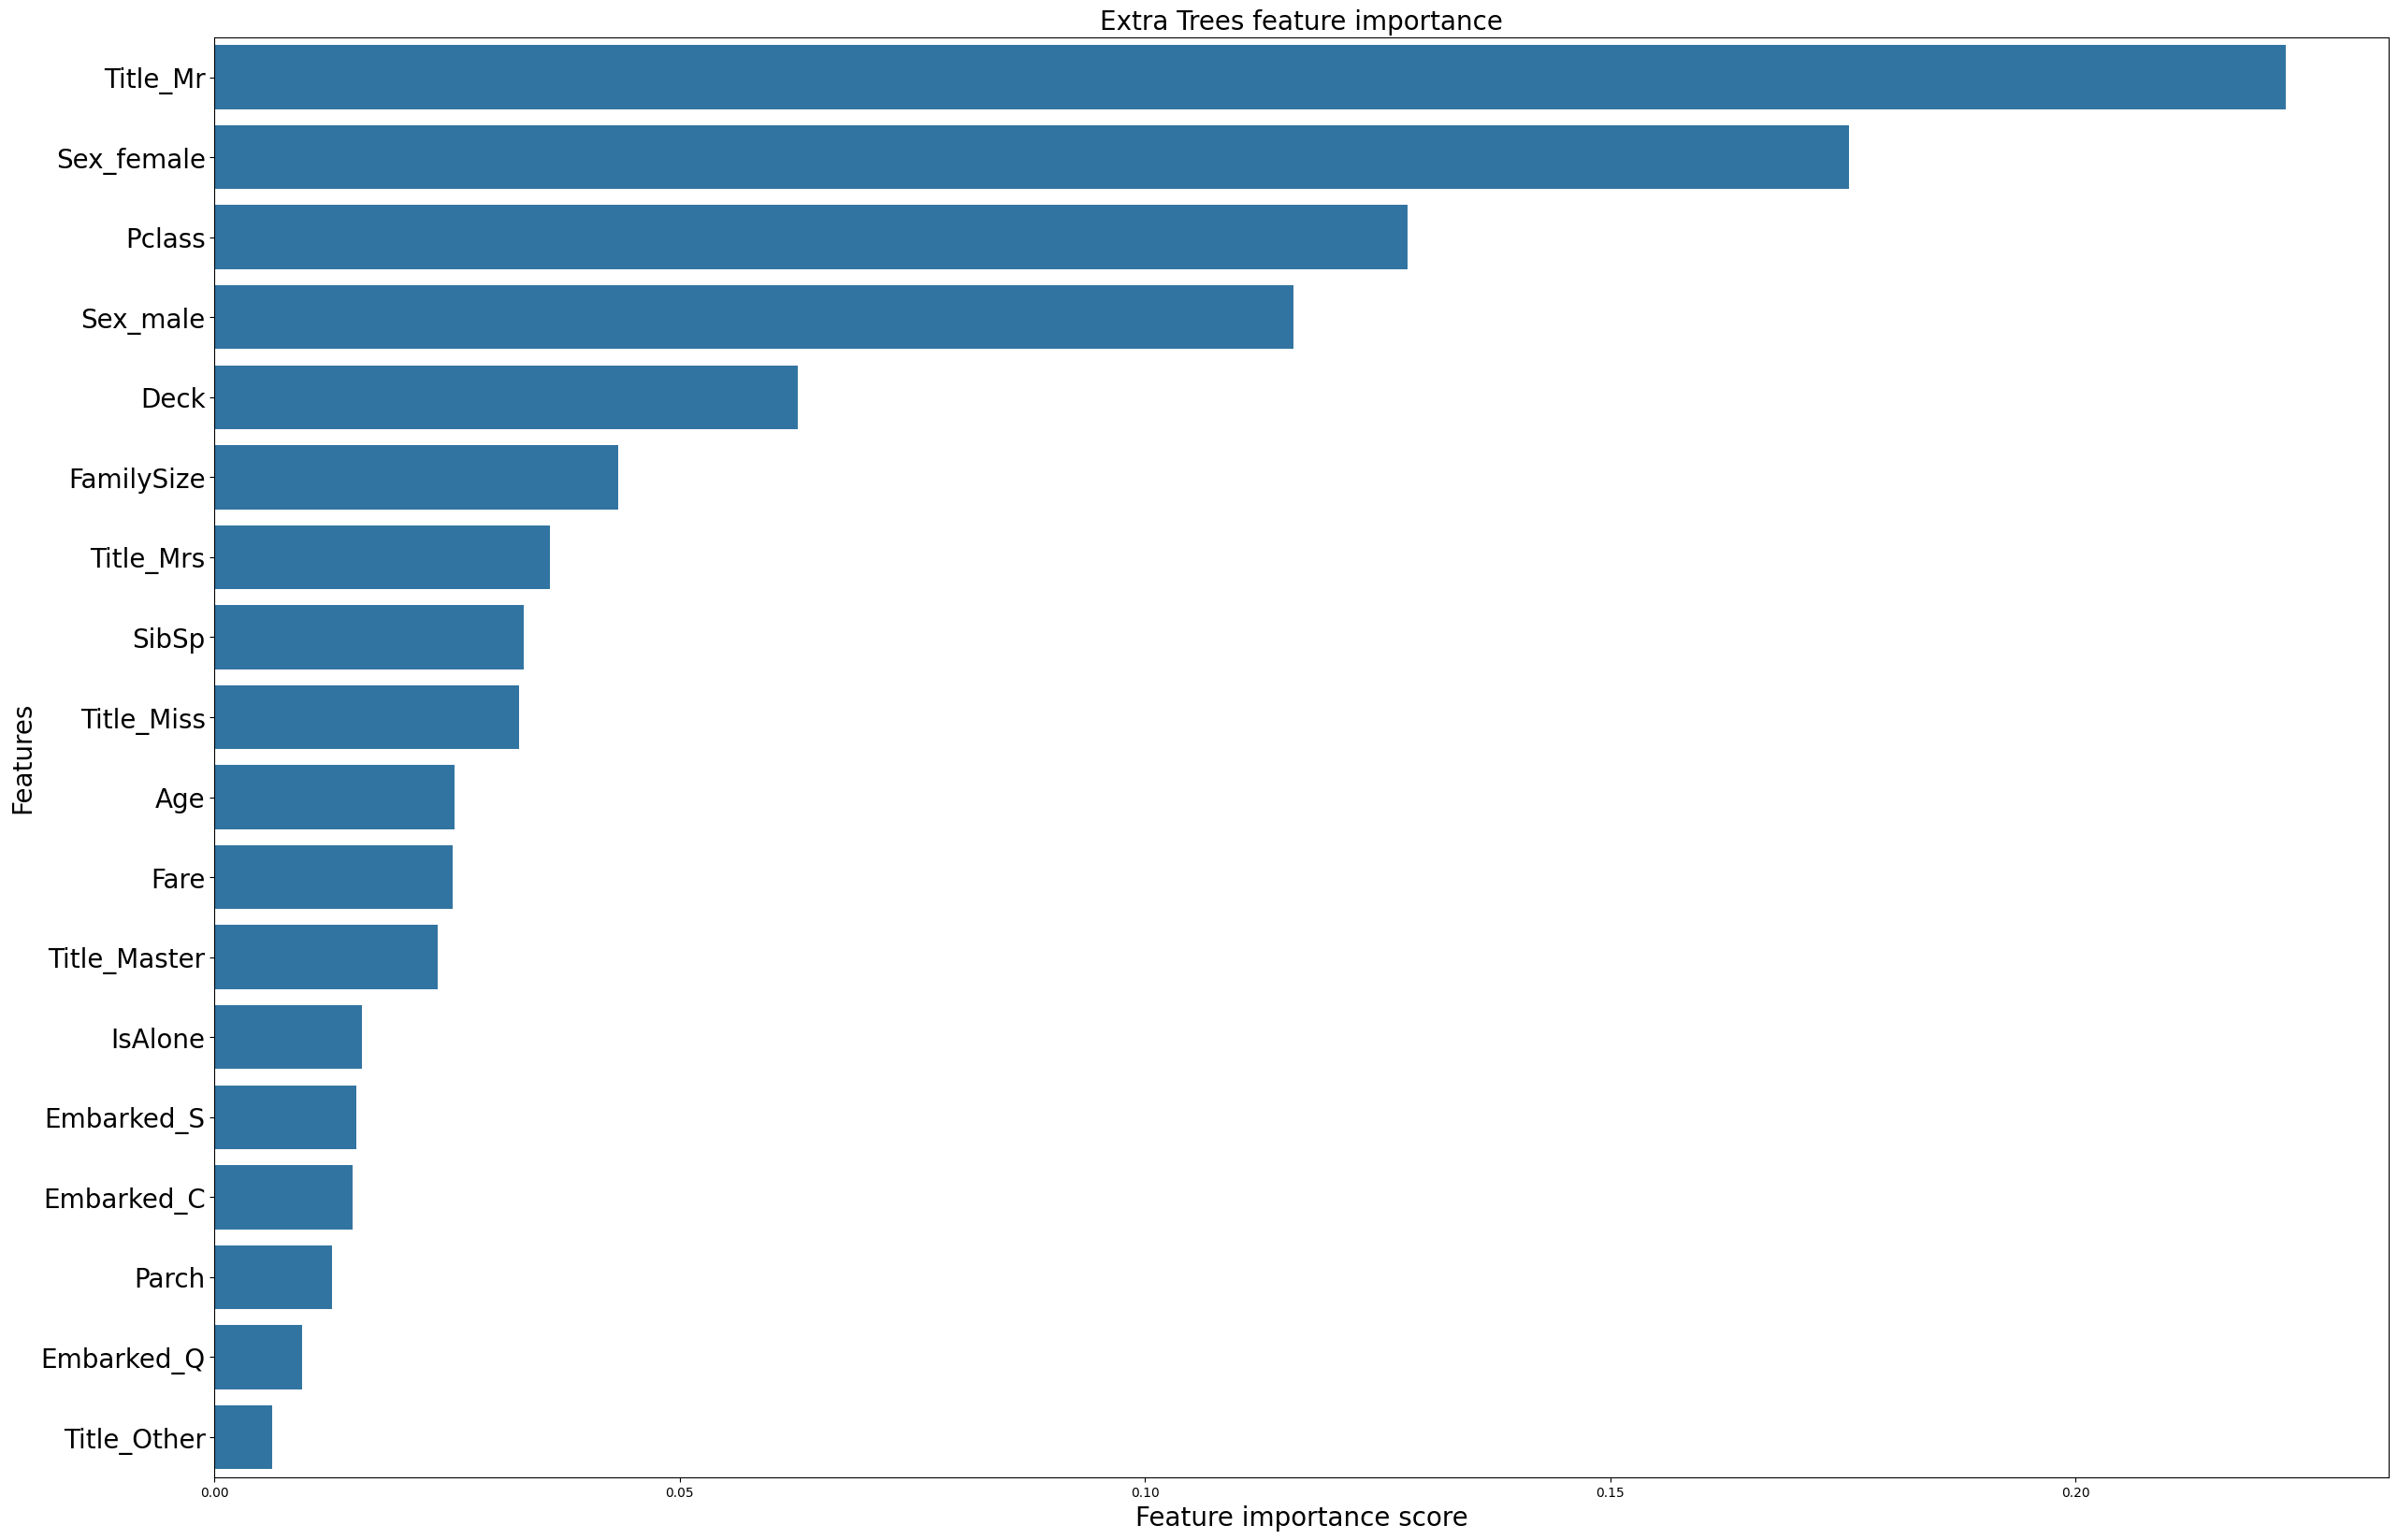

In [75]:
# Get the feature importance from the extc_opt classifier using extc_opt.feature_importances_
# Cast it into a pd.DataFrame and use sort_values to sort by the importance 

feature_scores = pd.DataFrame(extc_opt.feature_importances_, 
                              index=X_train.columns, 
                              columns=['Importance'])
feature_scores.sort_values(by='Importance', ascending=False, inplace=True) 

# Plot the rf_opt.feature_importances_ in a barplot 
f, ax = plt.subplots(figsize=(30, 20))
ax = sns.barplot(x='Importance', y=feature_scores.index, data=feature_scores)
ax.set_title("Extra Trees feature importance", size = 20)
ax.set_yticklabels(feature_scores.index, size = 20)
ax.set_xlabel("Feature importance score", size = 20)
ax.set_ylabel("Features", size = 20)
plt.show()

In [76]:
# Add the results of the optimal Extra Trees classifier as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Extra Trees',
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_extc_opt),3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_extc_opt), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76
0,Benchmark Linear SVM,0.82,0.74
0,Tuned Random Forest,0.82,0.74
0,Benchmark Decision Tree,0.78,0.71
0,LogisticRegression,0.83,0.76
0,Extra Trees,0.84,0.78


#### (OPTIONAL) Other models: Ensemble with Voting (heterogeneous models)

In [77]:
from sklearn.ensemble import VotingClassifier

# Build a Voting Ensemble model with some heterogeneous models with pre-defined parameters 
# Alternatively, you can use the combination of optimized (tuned) models 

ensemble =VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                      ('RBF', SVC(probability=True, kernel='rbf', C=0.5,gamma=0.1)),
                                      ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                      ('LR',  LogisticRegression(C=0.05)),
                                      ('DT',  DecisionTreeClassifier(random_state=0)),
                                      ('NB',  GaussianNB()),
                                      ('svm', SVC(kernel='rbf',probability=True))
                                     ], 
                       voting='soft')

ensemble.fit(X_train, y_train) 
y_pred_ensemble = ensemble.predict(X_test)

print('The accuracy for ensembled model is:', ensemble.score(X_test, y_test))
print('\n', metrics.classification_report(y_test, y_pred_ensemble))

The accuracy for ensembled model is: 0.835820895522388

               precision    recall  f1-score   support

           0       0.84      0.90      0.87       165
           1       0.82      0.73      0.77       103

    accuracy                           0.84       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.84      0.84      0.83       268



In [78]:
##### YOU CAN TUNE THE PARAMETERS OF THE VOTING ENSEMBLE TO FIND THE OPTIMAL MODEL 
# OR COMBINE THE OPTIMAL MODELS FROM THE VARIOUS TUNING PROCESSES #####

In [79]:
# Add the results of the Voting Ensemble model (heterogeneous) as a new row into clf_results that collects all the results across all models

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Voting Ensemble model (heterogeneous)',
                                                         'Accuracy': round(ensemble.score(X_test, y_test),3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_ensemble), 3)})])

clf_results

,Model,Accuracy,F1
0,Benchmark RBF SVM,0.84,0.77
0,Tuned SVM,0.84,0.77
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76
0,Benchmark Linear SVM,0.82,0.74
0,Tuned Random Forest,0.82,0.74
0,Benchmark Decision Tree,0.78,0.71
0,LogisticRegression,0.83,0.76
0,Extra Trees,0.84,0.78
0,Voting Ensemble model (heterogeneous),0.84,0.77


#### Compare once more all the models

In [80]:
clf_results.sort_values(by='F1', ascending=False, inplace=True)
clf_results

,Model,Accuracy,F1
0,Extra Trees,0.84,0.78
0,Voting Ensemble model (heterogeneous),0.84,0.77
0,Benchmark RBF SVM,0.84,0.77
0,Tuned SVM,0.84,0.77
0,LogisticRegression,0.83,0.76
0,Tuned KNN,0.83,0.76
0,Benchmark RF,0.82,0.76
0,Benchmark Linear SVM,0.82,0.74
0,Tuned Random Forest,0.82,0.74
0,Benchmark Decision Tree,0.78,0.71


### Classifiers - Predict the unknown test set

Using the patterns you find in train.csv, you have to predict whether the other 418 passengers on board (in test.csv) survived.

##### Case 1: use a single optimal (tuned) model 

Let's assume we want to use the optimal Random Forest to make the predictions on our final test (unknown) dataset: 

In [81]:
##  Can you use any optimal model to predict the classes of your unknownData? 


In [82]:
## Check the distribution of your y_pred to investigate how your model did 

In [83]:
# Save as csv file 
# output.to_csv('submission.csv', index=False)